# 아파트 실거래가 예측

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import re
import optuna
from optuna.integration import XGBoostPruningCallback
sns.set_theme(style="darkgrid")


## Data Load

In [2]:
train_df = pd.read_csv('./input/train.csv')
test_df = pd.read_csv('./input/test.csv')

In [3]:
train_df.head(3)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,0,7622,서울특별시,신교동,6-13,신현(101동),신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.74,2007,200801,1~10,6,38500


In [4]:
test_df.head(3)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor
0,1145756,10453,서울특별시,목동,938,청학,목동 938 청학,35.55,2002,201711,11~20,2
1,1198704,989,부산광역시,초량동,1143-8,고관맨션,초량동 1143-8 고관맨션,68.72,1977,201708,21~31,2
2,1222384,8597,부산광역시,괴정동,447-13,우림그린,괴정동 447-13 우림그린,72.54,1989,201710,11~20,2


- exclusive_use_area: 전용면적(한 세대만 독점적으로 사용하는 공간)
- transaction_real_price: 실거래가(단위:만원, 타겟 값, train만 존재)
- transaction_year_month: 거래년월
- transaction_date: 거래일
- floor: 층 

- 데이터가 거래시간 순으로 이루어져 있습니다.

In [5]:
print(train_df.shape)
print(test_df.shape)

(1216553, 13)
(5463, 12)


- 처음부터 train 데이터와 test데이터가 분리되어 있습니다. (id가 겹치지 않습니다.)
    - train data: 1216552행 13열로 구성
    - test data: 5463행 12열로 구성 (예측변수 'transaction_real_price'는 제외됨)

In [6]:
train_df.head(5)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,0,7622,서울특별시,신교동,6-13,신현(101동),신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.74,2007,200801,1~10,6,38500
3,3,10957,서울특별시,내수동,95,파크팰리스,내수동 95 파크팰리스,146.39,2003,200801,11~20,15,118000
4,4,10639,서울특별시,내수동,110-15,킹스매너,내수동 110-15 킹스매너,194.43,2004,200801,21~31,3,120000


In [7]:
train_df.describe() 

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price
count,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06
mean,6.091530e+05,6.299685e+03,7.816549e+01,1.998297e+03,2.012984e+05,9.343291e+00,3.822769e+04
std,3.526198e+05,3.581169e+03,2.915113e+01,8.941347e+00,2.905732e+02,6.606500e+00,3.104898e+04
min,0.000000e+00,0.000000e+00,9.260000e+00,1.961000e+03,2.008010e+05,-4.000000e+00,1.000000e+02
25%,3.041380e+05,3.345000e+03,5.976000e+01,1.993000e+03,2.010100e+05,4.000000e+00,1.900000e+04
50%,6.082760e+05,5.964000e+03,8.241000e+01,1.999000e+03,2.013120e+05,8.000000e+00,3.090000e+04
75%,9.124140e+05,9.436000e+03,8.497000e+01,2.005000e+03,2.015110e+05,1.300000e+01,4.700000e+04
max,1.234827e+06,1.265800e+04,4.243200e+02,2.017000e+03,2.017110e+05,8.000000e+01,8.200000e+05


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216553 entries, 0 to 1216552
Data columns (total 13 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   transaction_id          1216553 non-null  int64  
 1   apartment_id            1216553 non-null  int64  
 2   city                    1216553 non-null  object 
 3   dong                    1216553 non-null  object 
 4   jibun                   1216553 non-null  object 
 5   apt                     1216553 non-null  object 
 6   addr_kr                 1216553 non-null  object 
 7   exclusive_use_area      1216553 non-null  float64
 8   year_of_completion      1216553 non-null  int64  
 9   transaction_year_month  1216553 non-null  int64  
 10  transaction_date        1216553 non-null  object 
 11  floor                   1216553 non-null  int64  
 12  transaction_real_price  1216553 non-null  int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 120.7+ M

- train_df 결측치는 없습니다.
- 건물들은 1961년 ~ 2017년에 완공됐습니다.
- 9.26m^2 ~ 424.32m^2 전용면적을 가지고 있습니다.
- Floor의 경우 음의 값이 존재합니다.
- 실거래가는 100만원부터 820억까지 존재합니다.

In [9]:
train_df.loc[train_df['transaction_real_price']==820000]

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
23603,23603,11320,서울특별시,한남동,810,한남더힐,한남동 810 한남더힐,244.749,2011,201612,21~31,3,820000


In [10]:
test_df.describe()

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor
count,5.463000e+03,5463.000000,5463.000000,5463.000000,5463.000000,5463.000000
mean,1.167126e+06,6287.570932,79.495250,2000.431082,201710.228446,8.266886
std,4.075365e+04,3624.756304,32.935434,9.982040,2.798195,6.082475
min,1.092791e+06,12.000000,10.321500,1961.000000,201701.000000,-1.000000
25%,1.134296e+06,3278.000000,59.760000,1995.000000,201709.000000,4.000000
50%,1.167937e+06,6091.000000,81.720000,2002.000000,201712.000000,7.000000
75%,1.202560e+06,9416.500000,84.970000,2007.000000,201712.000000,11.000000
max,1.234930e+06,12652.000000,273.860000,2017.000000,201712.000000,55.000000


- test 데이터는 거래 연월이 2017년 데이터만 존재합니다.
- 완공연도는 train과 동일합니다.
- 층은 -1층부터 존재합니다.

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5463 entries, 0 to 5462
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   transaction_id          5463 non-null   int64  
 1   apartment_id            5463 non-null   int64  
 2   city                    5463 non-null   object 
 3   dong                    5463 non-null   object 
 4   jibun                   5463 non-null   object 
 5   apt                     5463 non-null   object 
 6   addr_kr                 5463 non-null   object 
 7   exclusive_use_area      5463 non-null   float64
 8   year_of_completion      5463 non-null   int64  
 9   transaction_year_month  5463 non-null   int64  
 10  transaction_date        5463 non-null   object 
 11  floor                   5463 non-null   int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 512.3+ KB


- 마찬가지로 결측치는 없습니다.

## Preprocessing

### apart

In [12]:
train_df.head(1)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,0,7622,서울특별시,신교동,6-13,신현(101동),신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500


- 신현(101동)과 신현(102동)의 가격차이가 클까요?
- apt 이름에 존재하는 괄호 + 괄호안 내용을 제거해서 통일하겠습니다.

In [13]:
#괄호와 괄호안내용 제거
regex = "\(.*\)|\s-\s.*"
for i in tqdm(range(len(train_df))):
   train_df.at[i, 'apt'] = re.sub(regex, '', train_df.at[i, 'apt'])
for i in tqdm(range(len(test_df))):
   test_df.at[i, 'apt'] = re.sub(regex, '', test_df.at[i, 'apt'])   

100%|██████████| 5463/5463 [00:00<00:00, 68390.49it/s]


In [14]:
train_df['apt'].value_counts()[:20]

현대        17716
한신        10135
삼성         6771
대우         6390
신동아        6386
두산         5801
우성         5781
주공2        5669
삼성래미안      5483
벽산         4651
대림         4582
동원로얄듀크     4430
경남         4030
삼환         3896
극동         3771
삼익         3583
롯데캐슬       3570
쌍용         3409
코오롱        3320
한양         3231
Name: apt, dtype: int64

- 아파트 이름이 많이 겹치는 것을 알 수 있습니다.
- 아파트별로 몇 채가 있는지를 나타내는 `apt_counts` 피쳐를 새로 만들겠습니다.

In [15]:
# 같은 아파트 이름을 갖는 수를 저장하는 apt_counts 열 생성
train_df['apt_counts'] = 0
train_df.groupby('apt')['apt_counts'].count()
train_df = pd.merge(train_df, train_df.groupby('apt')['apt_counts'].count(), on='apt', how='left').drop('apt_counts_x', axis=1).rename(columns={'apt_counts_y':'apt_counts'})

test_df['apt_counts'] = 0
test_df.groupby('apt')['apt_counts'].count()
test_df = pd.merge(test_df, test_df.groupby('apt')['apt_counts'].count(), on='apt', how='left').drop('apt_counts_x', axis=1).rename(columns={'apt_counts_y':'apt_counts'})

train_df.head(3)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,apt_counts
0,0,7622,서울특별시,신교동,6-13,신현,신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500,13
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000,1
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.74,2007,200801,1~10,6,38500,13


- 신교동 6-13 신현 (101동) 처럼 같은 아파트명을 갖는 아파트도 있지만, 필운동 142 사직파크맨션 같이 1개밖에 없는 아파트도 있습니다.
- 숫자 하나, 글자 하나만 달라져도 비슷한 아파트가 다르게 나오는건 별로 좋은 것 같지 않다고 생각합니다.
- top10 시공사 + 데이터에서 가장 많이 나오는 아파트 25개의 이름을 통일하겠습니다.
- top10 시공사 정보는 구글 검색을 통해 선정했습니다. (구글링도 공공데이터..는 아니지만 끝난대회니까 넘어가주세요. 아래의 top 10 시공사를 보시면 이정도면 뭐,, 하고 고개를 끄덕이실거라 생각합니다.)

In [16]:
# top 10 시공사 아파트 여부를 나타내는 컬럼 생성
train_df['top10'] = 0
test_df['top10'] = 0
top10 = ['자이', '푸르지오', '더샵', '롯데캐슬', '이편한|e편한|e-편한',
         '힐스테이트', '아이파크', '래미안', 'sk|SK|에스케이', '데시앙']

train_df['apt'] = train_df['apt'].fillna('others')
# top 10 시공사면 1, 아니면 0
for i, brand in enumerate(top10):
    train_df.loc[train_df['apt'].str.contains(brand), 'top10'] = 1
    test_df.loc[test_df['apt'].str.contains(brand), 'top10'] = 1


In [17]:
train_df.head(1)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,apt_counts,top10
0,0,7622,서울특별시,신교동,6-13,신현,신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500,13,0


In [18]:
# 데이터에 많이 있는 아파트 대표 25개 리스트
apt_names = ['그레이스', '양지', '쌍용', '현대', '한신', '삼성', '대우', '신동아', '두산', '주공',
             '우성', '벽산', '동원로얄듀크','경남', '삼환', '쌍용', '삼익', '대림', '코오롱', '파크리오',
             '엘지', '성원', '잠실', '동궁리치웰', '동성']
# top 10 시공사 키워드와 25개 리스트를 통합
apt_names_list = top10 + apt_names

# `apt_names_list`의 키워드에 해당하는 아파트명이 있는지 여부를 나타내는 새로운 컬럼 생성
train_df['transformed'] = False
test_df['transformed'] = False

# `apt_names_list`의 키워드에 아파트명이 포함되면 해당 키워드로 아파트명을 통일함
# 그리고 `transformed` 컬럼값을 True로 변경
for a in tqdm(apt_names_list):
    train_df.loc[train_df['apt'].str.contains(a), 'apt'] = a
    test_df.loc[test_df['apt'].str.contains(a), 'apt'] = a
    train_df.loc[train_df['apt'].str.contains(a), 'transformed'] = True
    test_df.loc[test_df['apt'].str.contains(a), 'transformed'] = True

# 아파트 이름이 변경되지 않았을 경우(`transformed=False` 일 경우) 아파트명을 'others'로 변경
for a in tqdm(apt_names):
    train_df.loc[~train_df['transformed'], 'apt'] = 'others'
    test_df.loc[~test_df['transformed'] , 'apt'] = 'others'

100%|██████████| 25/25 [00:00<00:00, 40.98it/s]


In [19]:
train_df['apt'].value_counts()

others          653503
현대               81824
주공               65937
래미안              32743
한신               27481
벽산               26968
우성               24524
롯데캐슬             24053
삼성               20067
sk|SK|에스케이       19709
두산               19501
삼익               18708
푸르지오             18416
쌍용               18256
대림               18194
대우               17786
이편한|e편한|e-편한     14337
신동아              14049
힐스테이트            11985
자이               11719
엘지               10938
경남               10875
코오롱               8602
아이파크              7989
성원                7601
더샵                6977
삼환                6073
동원로얄듀크            6070
파크리오              3094
잠실                2606
동성                2228
데시앙               2222
양지                1033
그레이스               393
동궁리치웰               92
Name: apt, dtype: int64

- 어마어마한 others 다음으로 현대가 가장 많네요
- 잘 처리가 된 것 같습니다.

In [20]:
print(train_df['apt'].nunique(), test_df['apt'].nunique())

35 35


- 아파트가 35개로 잘 통일된 것을 확인할 수 있습니다.
  
- 아파트명을 통일했으니, 각 아파트의 평균 가격을 확인해보고, 이를 내림차순으로 라벨인코딩을 해줍니다.

In [21]:
# 아파트별 가격의 평균 내림차순 정렬
apt_price = train_df.groupby('apt')['transaction_real_price'].agg('mean').sort_values(ascending=False)
print('변환전\n', apt_price[:5])

for i, a in enumerate(list(apt_price.index)):
    train_df.loc[train_df['apt'] == a, 'apt'] = i # 라벨 인코딩
    test_df.loc[test_df['apt'] == a, 'apt'] = i
apt_price = train_df.groupby('apt')['transaction_real_price'].agg('mean').sort_values(ascending=False)
print('변환후\n', apt_price[:5])

변환전
 apt
잠실      91273.525326
파크리오    88739.646736
자이      79838.112467
래미안     64184.531289
아이파크    63115.982726
Name: transaction_real_price, dtype: float64
변환후
 apt
0    91273.525326
1    88739.646736
2    79838.112467
3    64184.531289
4    63115.982726
Name: transaction_real_price, dtype: float64


- 잠실, 파크리오, 자이, 래미안, 아이파크 순으로 평균 실거래가 높네요. (잠실은 아마 저때보다 훨씬 높겠죠)?
- 라벨인코딩도 잘 된것을 확인합니다.

### date
apt 전처리는 마쳤으니, 이번에는 date로 넘어가봅시다.

In [22]:
train_df.head(1)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,apt_counts,top10,transformed
0,0,7622,서울특별시,신교동,6-13,23,신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500,13,0,False


In [23]:
train_df.describe()

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,apt_counts,top10
count,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06
mean,6.091530e+05,6.299685e+03,7.816549e+01,1.998297e+03,2.012984e+05,9.343291e+00,3.822769e+04,1.358148e+03,1.234225e-01
std,3.526198e+05,3.581169e+03,2.915113e+01,8.941347e+00,2.905732e+02,6.606500e+00,3.104898e+04,2.521461e+03,3.289217e-01
min,0.000000e+00,0.000000e+00,9.260000e+00,1.961000e+03,2.008010e+05,-4.000000e+00,1.000000e+02,1.000000e+00,0.000000e+00
25%,3.041380e+05,3.345000e+03,5.976000e+01,1.993000e+03,2.010100e+05,4.000000e+00,1.900000e+04,2.130000e+02,0.000000e+00
50%,6.082760e+05,5.964000e+03,8.241000e+01,1.999000e+03,2.013120e+05,8.000000e+00,3.090000e+04,5.950000e+02,0.000000e+00
75%,9.124140e+05,9.436000e+03,8.497000e+01,2.005000e+03,2.015110e+05,1.300000e+01,4.700000e+04,1.366000e+03,0.000000e+00
max,1.234827e+06,1.265800e+04,4.243200e+02,2.017000e+03,2.017110e+05,8.000000e+01,8.200000e+05,1.771600e+04,1.000000e+00


- 날짜 관련 컬럼은 `year_of_completion`, `transaction_year_month`, `transaction_date`가 있습니다.
- `transaction_date`는 0~10, 11~20, 21~30 총 세가지로 이루어져 있는데, 가격에 크게 영향을 미칠 것 같지 않아 제외합니다.
각 컬럼의 최대/최소가
- `year_of_completion`
    - 최소연도: 1961년
    - 최대연도: 2017년
- `transaction_year_month`
    - 최소연도: 2008년 1월
    - 최대연도: 2017년 11월
임을 확인합니다.
- 최대연도에서 최소연도를 빼면 정수형 라벨인코딩이 완성되겠죠?
- 사용하지 않을 열도 미리 제거하겠습니다.

주의할 점은 test 데이터의 라벨인코딩입니다.
- test 완공연도는 train 데이터와 동일하기 때문에 상관없습니다.
- 대신 거래연월이 2017년 01월부터 12월까지로만 이루어져 있기 때문에, 최소값을 빼면 train 라벨인코딩과 다른 값이 됩니다.
- 따라서 test의 거래연월에서 2017을 뺀 값에서 201701의 인코딩 값을 더해줍니다.


In [22]:
# test 시작 거래연월인 인덱스 저장
test_start = train_df.loc[train_df['transaction_year_month'] == 201701, 'transaction_year_month'].index[0]

In [23]:
# 완공연도에서 최소연도를 뺌으로써 완공연도 라벨인코딩
print('변환전\n', train_df['year_of_completion'].unique()[:5])
train_df['year_of_completion'] = train_df['year_of_completion'] - train_df['year_of_completion'].min()
test_df['year_of_completion'] = test_df['year_of_completion'] - test_df['year_of_completion'].min()
print('변환후\n', train_df['year_of_completion'].unique()[:5])

# 연월 증가하는 순으로 라벨 인코딩
print('train 변환전\n', train_df['transaction_year_month'].unique()[:5])
print('test 변환전\n', test_df['transaction_year_month'].unique()[:5])
le = LabelEncoder()
train_df['transaction_year_month'] = le.fit_transform(train_df['transaction_year_month'])
# test는 다음과 같이 처리
test_df['transaction_year_month'] = test_df['transaction_year_month'] - test_df['transaction_year_month'].min() + train_df.at[test_start, 'transaction_year_month']
print('train 변환후\n', train_df['transaction_year_month'].unique()[:5])
print('test 변환후\n', test_df['transaction_year_month'].unique()[:5])

# 필요없는 열 제거
train_df = train_df.drop(['jibun', 'transaction_date', 'addr_kr'], axis=1)
test_df = test_df.drop(['jibun', 'transaction_date', 'addr_kr'], axis=1)

변환전
 [2002 1973 2007 2003 2004]
변환후
 [41 12 46 42 43]
train 변환전
 [200801 200802 200803 200804 200805]
test 변환전
 [201711 201708 201710 201707 201712]
train 변환후
 [0 1 2 3 4]
test 변환후
 [118 115 117 114 119]


In [24]:
train_df.head(5)

,transaction_id,apartment_id,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,apt_counts,top10,transformed
0,0,7622,서울특별시,신교동,23,84.82,41,0,2,37500,13,0,False
1,1,5399,서울특별시,필운동,23,99.17,12,0,6,20000,1,0,False
2,2,3578,서울특별시,필운동,23,84.74,46,0,6,38500,13,0,False
3,3,10957,서울특별시,내수동,23,146.39,42,0,15,118000,55,0,False
4,4,10639,서울특별시,내수동,23,194.43,43,0,3,120000,15,0,False


In [25]:
test_df

,transaction_id,apartment_id,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,apt_counts,top10,transformed
0,1145756,10453,서울특별시,목동,23,35.5500,41,118,2,1,0,False
1,1198704,989,부산광역시,초량동,23,68.7200,16,115,2,1,0,False
2,1222384,8597,부산광역시,괴정동,23,72.5400,28,117,2,1,0,False
3,1179897,11086,서울특별시,대치동,23,111.5400,43,114,10,2,0,False
4,1223091,2121,부산광역시,다대동,10,119.6398,53,119,21,3,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...
5458,1174640,8965,서울특별시,양재동,23,84.0500,42,117,7,1,0,False
5459,1175575,3831,서울특별시,반포동,3,84.9300,48,119,4,2,1,True
5460,1157024,5550,서울특별시,구로동,3,110.1880,43,119,23,23,1,True
5461,1136863,3371,서울특별시,홍제동,23,92.4400,44,117,1,1,0,False


In [26]:
train_df.describe()

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,apt_counts,top10
count,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06
mean,6.091530e+05,6.299685e+03,7.816549e+01,3.729657e+01,6.437834e+01,9.343291e+00,3.822769e+04,1.358148e+03,1.234225e-01
std,3.526198e+05,3.581169e+03,2.915113e+01,8.941347e+00,3.509363e+01,6.606500e+00,3.104898e+04,2.521461e+03,3.289217e-01
min,0.000000e+00,0.000000e+00,9.260000e+00,0.000000e+00,0.000000e+00,-4.000000e+00,1.000000e+02,1.000000e+00,0.000000e+00
25%,3.041380e+05,3.345000e+03,5.976000e+01,3.200000e+01,3.300000e+01,4.000000e+00,1.900000e+04,2.130000e+02,0.000000e+00
50%,6.082760e+05,5.964000e+03,8.241000e+01,3.800000e+01,7.100000e+01,8.000000e+00,3.090000e+04,5.950000e+02,0.000000e+00
75%,9.124140e+05,9.436000e+03,8.497000e+01,4.400000e+01,9.400000e+01,1.300000e+01,4.700000e+04,1.366000e+03,0.000000e+00
max,1.234827e+06,1.265800e+04,4.243200e+02,5.600000e+01,1.180000e+02,8.000000e+01,8.200000e+05,1.771600e+04,1.000000e+00


In [27]:
test_df.describe()

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor,apt_counts,top10
count,5.463000e+03,5463.000000,5463.000000,5463.000000,5463.000000,5463.000000,5463.000000,5463.000000
mean,1.167126e+06,6287.570932,79.495250,39.431082,117.228446,8.266886,4.573861,0.119714
std,4.075365e+04,3624.756304,32.935434,9.982040,2.798195,6.082475,8.417214,0.324657
min,1.092791e+06,12.000000,10.321500,0.000000,108.000000,-1.000000,1.000000,0.000000
25%,1.134296e+06,3278.000000,59.760000,34.000000,116.000000,4.000000,1.000000,0.000000
50%,1.167937e+06,6091.000000,81.720000,41.000000,119.000000,7.000000,2.000000,0.000000
75%,1.202560e+06,9416.500000,84.970000,46.000000,119.000000,11.000000,4.000000,0.000000
max,1.234930e+06,12652.000000,273.860000,56.000000,119.000000,55.000000,61.000000,1.000000


### dong
- 이번에는 주소의 동입니다.
- 먼저 서울과 부산에서 같은 이름을 가진 동이 있는지 확인해보겠습니다.

In [36]:
train_df = train_df.drop('dong', axis=1)
test_df = test_df.drop('dong', axis=1)

### Floor

In [33]:
train_df.describe()

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,apt_counts,top10
count,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06
mean,6.091530e+05,6.299685e+03,7.816549e+01,3.729657e+01,6.437834e+01,9.343291e+00,3.822769e+04,1.358148e+03,1.234225e-01
std,3.526198e+05,3.581169e+03,2.915113e+01,8.941347e+00,3.509363e+01,6.606500e+00,3.104898e+04,2.521461e+03,3.289217e-01
min,0.000000e+00,0.000000e+00,9.260000e+00,0.000000e+00,0.000000e+00,-4.000000e+00,1.000000e+02,1.000000e+00,0.000000e+00
25%,3.041380e+05,3.345000e+03,5.976000e+01,3.200000e+01,3.300000e+01,4.000000e+00,1.900000e+04,2.130000e+02,0.000000e+00
50%,6.082760e+05,5.964000e+03,8.241000e+01,3.800000e+01,7.100000e+01,8.000000e+00,3.090000e+04,5.950000e+02,0.000000e+00
75%,9.124140e+05,9.436000e+03,8.497000e+01,4.400000e+01,9.400000e+01,1.300000e+01,4.700000e+04,1.366000e+03,0.000000e+00
max,1.234827e+06,1.265800e+04,4.243200e+02,5.600000e+01,1.180000e+02,8.000000e+01,8.200000e+05,1.771600e+04,1.000000e+00


- 최소층이 -4층임을 확인할 수 있습니다.
- 4를 더해서 라벨인코딩을 진행해줍니다.
- test는 최소층이 -1층이었으니 맞게 변환합니다.

In [37]:
# 최소값이 -4이므로 4를 더해서 음수를 없애고 순서형범주처리
print('변환전\n', train_df['floor'].values[:5])
train_df['floor'] = train_df['floor'].map(lambda x: x+4)
test_df['floor'] = test_df['floor'].map(lambda x: x+1)
print('변환후\n', train_df['floor'].values[:5])

변환전
 [ 2  6  6 15  3]
변환후
 [ 6 10 10 19  7]


### Price
- 이제 타겟데이터를 살펴보겠습니다.

<Figure size 432x288 with 0 Axes>

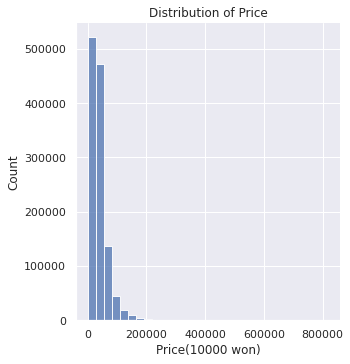

In [38]:
# train price
plt.figure()
sns.displot(train_df['transaction_real_price'], bins=30)
plt.xlabel('Price(10000 won)')
plt.title('Distribution of Price')
plt.show()

- 가격의 분포가 매우 왼쪽으로 치우친 것을 확인할 수 있습니다.
- 타겟 변수의 이상치가 회귀모형을 사용한 예측에 큰 영향을 줄 수 있으니,
    - 로그 변환으로 정규화한뒤, 나중에 다시 역변환하겠습니다!

In [39]:
# 가격 로그 변환 후 원래 가격 따로 저장
train_df['log_price'] = np.log1p(train_df['transaction_real_price'])
real_price = train_df['transaction_real_price'] # 원래 가격
train_df.drop('transaction_real_price', axis=1, inplace=True)
train_df.head(1)

,transaction_id,apartment_id,city,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,apt_counts,top10,transformed,log_price
0,0,7622,서울특별시,23,84.82,41,0,6,13,0,False,10.532123


- 잘 변환이 됐는지 그래프를 그려보겠습니다.

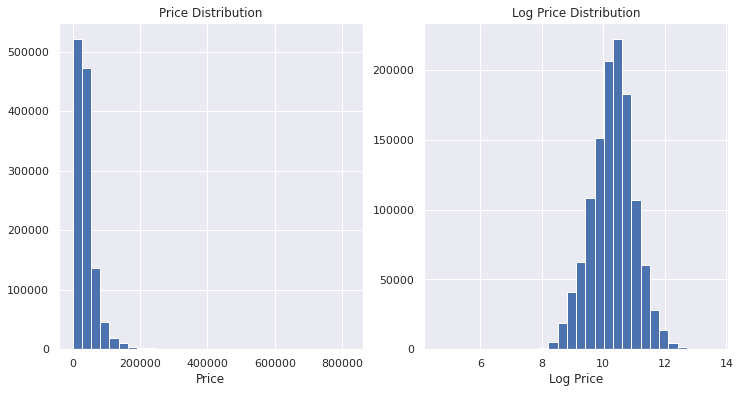

In [40]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(real_price, bins=30)
ax1.set_title('Price Distribution')
ax1.set_xlabel('Price')

ax2.hist(train_df['log_price'], bins=30)
ax2.set_title('Log Price Distribution')
ax2.set_xlabel('Log Price')

plt.show()

- 가격이 정규분포처럼 잘 근사됐네요 :)

### Area
- 면적도 가격과 동일하게!

<Figure size 432x288 with 0 Axes>

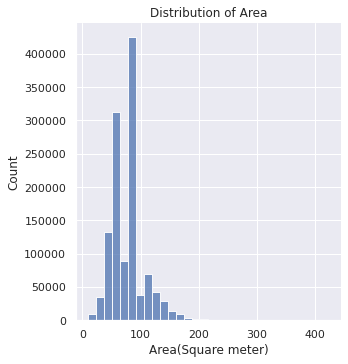

In [41]:
# train area
plt.figure()
sns.displot(train_df['exclusive_use_area'], bins=30)
plt.xlabel('Area(Square meter)')
plt.title('Distribution of Area')
plt.show()

In [42]:
# 면적 로그 변환 후 원래 면적 따로 저장
train_df['log_area'] = np.log1p(train_df['exclusive_use_area'])
test_df['log_area'] = np.log1p(test_df['exclusive_use_area'])
area = train_df['exclusive_use_area'] # 원래 가격
train_df.drop('exclusive_use_area', axis=1, inplace=True)
test_df.drop('exclusive_use_area', axis=1, inplace=True)
train_df.head(1)

,transaction_id,apartment_id,city,apt,year_of_completion,transaction_year_month,floor,apt_counts,top10,transformed,log_price,log_area
0,0,7622,서울특별시,23,41,0,6,13,0,False,10.532123,4.452252


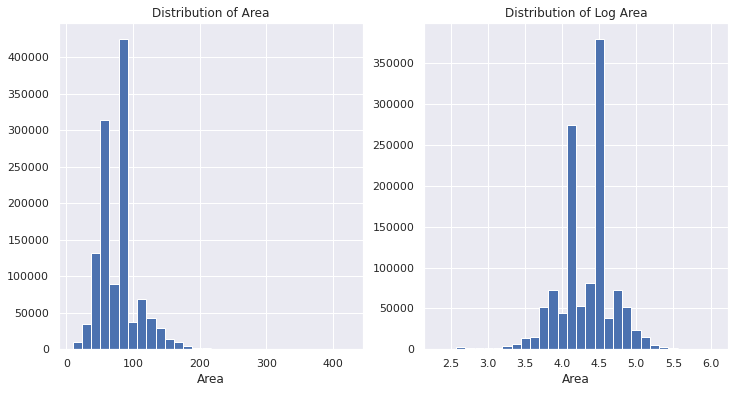

In [43]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(area, bins=30)
ax1.set_title('Distribution of Area')
ax1.set_xlabel('Area')

ax2.hist(train_df['log_area'], bins=30)
ax2.set_title('Distribution of Log Area')
ax2.set_xlabel('Area')

plt.show()

- 가격만큼 만족스럽진 않지만.. 그냥 쓰겠습니다 ㅎㅎ

### Encoding
- 인코딩은 이제 `city`만 진행하면 됩니다.
- `city`는 서울특별시면 1, 부산광역시면 0으로 변환하겠습니다.
- 학습에 사용하지 않을 피쳐들도 제거하겠습니다.

In [44]:
drop_col = ['transaction_id', 'apartment_id', 'apt_counts', 'transformed']

train_df['city'] = train_df['city'].map(lambda x: 1 if x == '서울특별시' else 0)
test_df['city'] = test_df['city'].map(lambda x: 1 if x == '서울특별시' else 0)

In [45]:
train_df.drop(drop_col, axis=1, inplace=True)
test_df.drop(drop_col, axis=1, inplace=True)
train_df.head(1)

,city,apt,year_of_completion,transaction_year_month,floor,top10,log_price,log_area
0,1,23,41,0,6,0,10.532123,4.452252


In [46]:
test_df.head(1)

,city,apt,year_of_completion,transaction_year_month,floor,top10,log_area
0,1,23,41,118,3,0,3.598681


In [46]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216553 entries, 0 to 1216552
Data columns (total 9 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   city                    1216553 non-null  int64  
 1   dong                    1216553 non-null  object 
 2   apt                     1216553 non-null  object 
 3   year_of_completion      1216553 non-null  int64  
 4   transaction_year_month  1216553 non-null  int64  
 5   floor                   1216553 non-null  int64  
 6   top10                   1216553 non-null  int64  
 7   log_price               1216553 non-null  float64
 8   log_area                1216553 non-null  float64
dtypes: float64(2), int64(5), object(2)
memory usage: 125.1+ MB


- `dong`과 `apt`는 정수여야 하는데 object 자료형입니다.
- 후에 XGBoost와 LightGBM에서 오류가 발생하기 때문에, int 자료형으로 변환하겠습니다.

In [59]:
# train_df['dong'] = train_df['dong'].astype('int64')
train_df['apt'] = train_df['apt'].astype('int64')
# test_df['dong'] = test_df['dong'].astype('int64')
test_df['apt'] = test_df['apt'].astype('int64')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216553 entries, 0 to 1216552
Data columns (total 8 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   city                    1216553 non-null  int64  
 1   apt                     1216553 non-null  int64  
 2   year_of_completion      1216553 non-null  int64  
 3   transaction_year_month  1216553 non-null  int64  
 4   floor                   1216553 non-null  int64  
 5   top10                   1216553 non-null  int64  
 6   log_price               1216553 non-null  float64
 7   log_area                1216553 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 115.8 MB


In [60]:
print(train_df.shape, test_df.shape)

(1216553, 8) (5463, 7)


In [61]:
train_X, train_y = train_df.drop(['log_price'], axis=1), train_df['log_price']
print(train_X.shape, train_y.shape)

(1216553, 7) (1216553,)


In [62]:
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

def rmse_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=10)
    rmse_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        rmse = RMSE(y_test, pred) 
        rmse_list.append(rmse)
    return model_name, rmse_list

def print_rmse_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = rmse_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} RMSLE: {r:.4f}')
    print(f'\n{model_name} mean RMSLE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

- 간단하게 모델을 정의합니다.

In [63]:
reg = LinearRegression(n_jobs=-1)
ridge = Ridge(alpha=0.8, random_state=1)
lasso = Lasso(alpha = 0.01, random_state=1)
Enet = ElasticNet(alpha=0.03, l1_ratio=0.01, random_state=1)
DTree = DecisionTreeRegressor(max_depth=6, min_samples_split=10, min_samples_leaf=15, random_state=1)
rf = RandomForestRegressor(n_estimators=500, criterion='mse', max_depth=9, min_samples_split=50,
                           min_samples_leaf=5, random_state=1, n_jobs=-1)
model_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=9, min_child_weight=5, gamma=0.1, n_jobs=-1)
model_lgb = lgb.LGBMRegressor(n_estimators=500, max_depth=9, min_child_weight=5, n_jobs=-1)

- 학습을 시키고 성능을 테스트합니다.
- i9-10980XE CPU를 사용했을 때, 아래의 CV 시간은 약 800초 정도 소요됩니다.

In [64]:
models = []
scores = []
for model in [reg, ridge, lasso, Enet, DTree, model_lgb]:
    model_name, mean_score = print_rmse_score(model)
    models.append(model_name)
    scores.append(mean_score)

LinearRegression Cross Validations...: 100%|██████████| 10/10 [00:01<00:00,  7.66it/s]


1 FOLDS: LinearRegression RMSLE: 0.2785
2 FOLDS: LinearRegression RMSLE: 0.3196
3 FOLDS: LinearRegression RMSLE: 0.2591
4 FOLDS: LinearRegression RMSLE: 0.5875
5 FOLDS: LinearRegression RMSLE: 0.6013
6 FOLDS: LinearRegression RMSLE: 0.3844
7 FOLDS: LinearRegression RMSLE: 0.3536
8 FOLDS: LinearRegression RMSLE: 0.3596
9 FOLDS: LinearRegression RMSLE: 0.3179
10 FOLDS: LinearRegression RMSLE: 0.4013

LinearRegression mean RMSLE: 0.3863


Ridge Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 12.11it/s]


1 FOLDS: Ridge RMSLE: 0.2785
2 FOLDS: Ridge RMSLE: 0.3196
3 FOLDS: Ridge RMSLE: 0.2591
4 FOLDS: Ridge RMSLE: 0.5875
5 FOLDS: Ridge RMSLE: 0.6013
6 FOLDS: Ridge RMSLE: 0.3844
7 FOLDS: Ridge RMSLE: 0.3536
8 FOLDS: Ridge RMSLE: 0.3596
9 FOLDS: Ridge RMSLE: 0.3179
10 FOLDS: Ridge RMSLE: 0.4013

Ridge mean RMSLE: 0.3863


Lasso Cross Validations...: 100%|██████████| 10/10 [00:01<00:00,  6.95it/s]


1 FOLDS: Lasso RMSLE: 0.2852
2 FOLDS: Lasso RMSLE: 0.3190
3 FOLDS: Lasso RMSLE: 0.2586
4 FOLDS: Lasso RMSLE: 0.5976
5 FOLDS: Lasso RMSLE: 0.5993
6 FOLDS: Lasso RMSLE: 0.5400
7 FOLDS: Lasso RMSLE: 0.3609
8 FOLDS: Lasso RMSLE: 0.3683
9 FOLDS: Lasso RMSLE: 0.3201
10 FOLDS: Lasso RMSLE: 0.3984

Lasso mean RMSLE: 0.4047


ElasticNet Cross Validations...: 100%|██████████| 10/10 [00:01<00:00,  6.34it/s]


1 FOLDS: ElasticNet RMSLE: 0.2972
2 FOLDS: ElasticNet RMSLE: 0.3244
3 FOLDS: ElasticNet RMSLE: 0.2631
4 FOLDS: ElasticNet RMSLE: 0.6120
5 FOLDS: ElasticNet RMSLE: 0.5996
6 FOLDS: ElasticNet RMSLE: 0.5963
7 FOLDS: ElasticNet RMSLE: 0.3797
8 FOLDS: ElasticNet RMSLE: 0.3803
9 FOLDS: ElasticNet RMSLE: 0.3291
10 FOLDS: ElasticNet RMSLE: 0.3995

ElasticNet mean RMSLE: 0.4181


DecisionTreeRegressor Cross Validations...: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


1 FOLDS: DecisionTreeRegressor RMSLE: 0.2585
2 FOLDS: DecisionTreeRegressor RMSLE: 0.3219
3 FOLDS: DecisionTreeRegressor RMSLE: 0.2574
4 FOLDS: DecisionTreeRegressor RMSLE: 0.5501
5 FOLDS: DecisionTreeRegressor RMSLE: 0.5564
6 FOLDS: DecisionTreeRegressor RMSLE: 0.4270
7 FOLDS: DecisionTreeRegressor RMSLE: 0.3207
8 FOLDS: DecisionTreeRegressor RMSLE: 0.3126
9 FOLDS: DecisionTreeRegressor RMSLE: 0.3222
10 FOLDS: DecisionTreeRegressor RMSLE: 0.3917

DecisionTreeRegressor mean RMSLE: 0.3719


LGBMRegressor Cross Validations...: 100%|██████████| 10/10 [00:24<00:00,  2.43s/it]

1 FOLDS: LGBMRegressor RMSLE: 0.2449
2 FOLDS: LGBMRegressor RMSLE: 0.3100
3 FOLDS: LGBMRegressor RMSLE: 0.2366
4 FOLDS: LGBMRegressor RMSLE: 0.5487
5 FOLDS: LGBMRegressor RMSLE: 0.5052
6 FOLDS: LGBMRegressor RMSLE: 0.2823
7 FOLDS: LGBMRegressor RMSLE: 0.2855
8 FOLDS: LGBMRegressor RMSLE: 0.2410
9 FOLDS: LGBMRegressor RMSLE: 0.2624
10 FOLDS: LGBMRegressor RMSLE: 0.2728

LGBMRegressor mean RMSLE: 0.3189


In [65]:
result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result_df

,Model,Score
0,LinearRegression,0.386279
1,Ridge,0.386277
2,Lasso,0.404749
3,ElasticNet,0.418120
4,DecisionTreeRegressor,0.371851
5,LGBMRegressor,0.318930


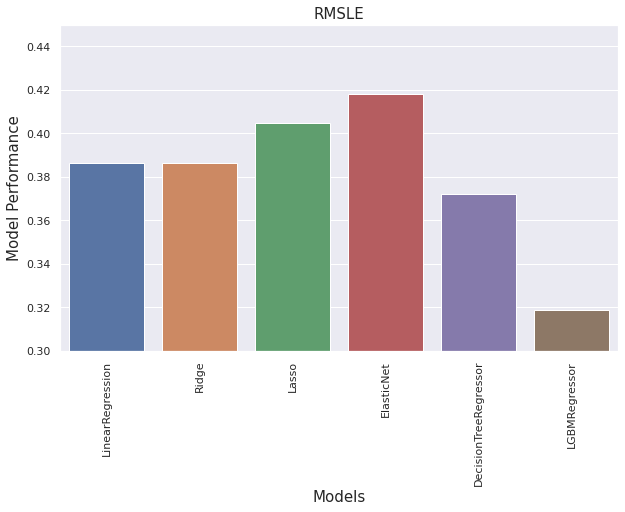

In [66]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0.3, 0.45)
plt.title('RMSLE', fontsize=15)
plt.show()

- CV 결과 LightGBM의 평균 RMSLE가 0.2395로 가장 작은 것을 알 수 있습니다.
- 이제, LightGBM을 이용하여 하이퍼 파라미터 튜닝을 진행하겠습니다. 

### Hyperparameter Tuning
- 시간적 비용을 고려하여, 하이퍼 파라미터 튜닝에서는 TimeSeries CV를 사용하지 않겠습니다.
- 대신 train 데이터를 8:2 비율로 분할하여 학습과 검증에 사용하겠습니다.
- 마찬가지로 데이터가 섞이지 않게, 검증 데이터는 train 데이터의 마지막 20%을 사용하겠습니다.

In [68]:
cut = int(len(train_df)*0.8)
h_train = train_df[:cut]
h_valid = train_df[cut:]

h_train_X = h_train.drop(['log_price'], axis=1)
h_train_y = h_train['log_price']
h_valid_X = h_valid.drop(['log_price'], axis=1)
h_valid_y = h_valid['log_price']
print(h_train_X.shape, h_train_y.shape, h_valid_X.shape, h_valid_y.shape)

(973242, 7) (973242,) (243311, 7) (243311,)


In [69]:
h_train_X.head()

,city,apt,year_of_completion,transaction_year_month,floor,top10,log_area
0,1,23,41,0,6,0,4.452252
1,1,23,12,0,10,0,4.606869
2,1,23,46,0,10,0,4.451319
3,1,23,42,0,19,0,4.993082
4,1,23,43,0,7,0,5.275202


- optuna를 사용하여 하이퍼 파라미터 튜닝을 진행합니다.
- 약 20분 정도 진행됩니다.

In [70]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=10)

def objective(trial):
    dtrain = lgb.Dataset(h_train_X, label=h_train_y)
    dtest = lgb.Dataset(h_valid_X, label=h_valid_y)

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)], verbose=0, early_stopping_rounds=25)
    rmse = RMSE(h_valid_y, lgb_model.predict(h_valid_X))
    return rmse
        
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

[I 2021-10-08 10:57:51,558] A new study created in memory with name: no-name-d37338e4-1902-4b21-a53c-dd287827f21d
[I 2021-10-08 10:58:09,824] Trial 0 finished with value: 0.7371363074481336 and parameters: {'max_depth': 13, 'learning_rate': 1.3320229150659043e-08, 'n_estimators': 1938, 'min_child_samples': 76, 'subsample': 0.6315909175774905}. Best is trial 0 with value: 0.7371363074481336.
[I 2021-10-08 10:58:28,595] Trial 1 finished with value: 0.7369503664466275 and parameters: {'max_depth': 5, 'learning_rate': 1.5430400149097381e-07, 'n_estimators': 2306, 'min_child_samples': 21, 'subsample': 0.4337244827306443}. Best is trial 1 with value: 0.7369503664466275.
[I 2021-10-08 10:58:29,766] Trial 2 finished with value: 0.5049596870719305 and parameters: {'max_depth': 11, 'learning_rate': 0.005252427629146827, 'n_estimators': 111, 'min_child_samples': 54, 'subsample': 0.8422371309477078}. Best is trial 2 with value: 0.5049596870719305.
[I 2021-10-08 10:58:38,638] Trial 3 finished with 

In [71]:
trial = study_lgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 0.2649944744756966,
params {'max_depth': 15, 'learning_rate': 0.009903235281344848, 'n_estimators': 2969, 'min_child_samples': 14, 'subsample': 0.4485593726625884}


- 처음에 LightGBM 평균 RMSLE가 0.2390임을 감안했을때, 매우 성능이 향상됐음을 알 수 있습니다.

## LightGBM Submission
- 이제 test 셋을 사용해서 inference를 해보고 실제 점수를 Dacon에서 확인해볼시간입니다.
- 먼저 train 데이터에서 진행한 모든 전처리를 test 데이터에도 적용합니다.

In [72]:
train_df.head()

,city,apt,year_of_completion,transaction_year_month,floor,top10,log_price,log_area
0,1,23,41,0,6,0,10.532123,4.452252
1,1,23,12,0,10,0,9.903538,4.606869
2,1,23,46,0,10,0,10.558439,4.451319
3,1,23,42,0,19,0,11.678448,4.993082
4,1,23,43,0,7,0,11.695255,5.275202


In [73]:
test_df.head()

,city,apt,year_of_completion,transaction_year_month,floor,top10,log_area
0,1,23,41,118,3,0,3.598681
1,0,23,16,115,3,0,4.244487
2,0,23,28,117,3,0,4.297829
3,1,23,43,114,11,0,4.723309
4,0,10,53,119,22,1,4.792809


In [75]:

final_lgb_model = lgb.LGBMRegressor(**trial_params)
final_lgb_model.fit(train_X, train_y)
final_lgb_pred = final_lgb_model.predict(test_df)

In [76]:
final_lgb_pred

array([ 9.84167782,  9.50950727,  9.46179336, ..., 11.28130007,
       10.66449222,  9.97341697])

<BarContainer object of 7 artists>

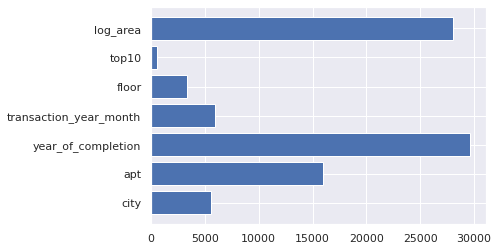

In [77]:
plt.barh(train_X.columns, final_lgb_model.feature_importances_)

- 동, 완공연도, 면적, 아파트명 순으로 중요도가 높다고 나옵니다.
- top 시공사는 별로 중요하지 않다고 하네요..

## Submission
- 이제 제출을 해봅시다.
- 가격을 다시 역변환합니다.

In [78]:
final_pred_sub = np.expm1(final_lgb_pred)
final_pred_sub

array([18800.23465347, 13486.34703954, 12857.92450997, ...,
       79323.32224339, 42807.51123102, 21447.64961527])

In [79]:
sub = pd.read_csv('./input/test.csv')
sub_df = pd.DataFrame({'transaction_id': sub['transaction_id'], 'transaction_real_price': final_pred_sub})
sub_df

,transaction_id,transaction_real_price
0,1145756,18800.234653
1,1198704,13486.347040
2,1222384,12857.924510
3,1179897,58182.963907
4,1223091,53350.314435
...,...,...
5458,1174640,47856.648864
5459,1175575,103513.067892
5460,1157024,79323.322243
5461,1136863,42807.511231


In [80]:
sub_df.to_csv('submission_lgb_wo_dong.csv', index=False)

여기까지 따라오시느라 고생하셨습니다.

긴 글 봐주셔서 감사합니다:)